<a href="https://colab.research.google.com/github/GTPB82/Azure-MachineLearning-DataScience/blob/master/Brain_Tumor_MRI_Classification_TensorFlow_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install pydicom

In [ ]:
# !pip install python-gdcm

In [4]:
import os
os.chdir('/content/drive/MyDrive/glioma/Brain tumor classification')
os.getcwd()

'/content/drive/MyDrive/glioma/Brain tumor classification'

In [5]:
!pip install tensorflow_io

     |████████████████████████████████| 23.4 MB 2.0 MB/s 


In [6]:
!pip install tensorflow

     |████████████████████████████████| 462 kB 5.4 MB/s 


In [5]:
import matplotlib.pyplot as plt
import numpy as np# linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)import seaborn as sns
import cv2
import tensorflow as tf
import tensorflow_io as tfio
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# from keras import EfficientNetB0
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.cluster import KMeans
import shutil
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,                             AutoMinorLocator)
import seaborn as sns
from IPython.display import HTML
import sys
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



In [6]:
# !pip list
print(tf.executing_eagerly())

True


In [ ]:
# %tensorflow_version 2.x
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [7]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/glioma/Brain tumor classification'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/glioma/Brain tumor classification/effnet.h5
/content/drive/MyDrive/glioma/Brain tumor classification/Testing/no_tumor/image(14).jpg
/content/drive/MyDrive/glioma/Brain tumor classification/Testing/no_tumor/image(76).jpg
/content/drive/MyDrive/glioma/Brain tumor classification/Testing/no_tumor/image(2).jpg
/content/drive/MyDrive/glioma/Brain tumor classification/Testing/no_tumor/image(104).jpg
/content/drive/MyDrive/glioma/Brain tumor classification/Testing/no_tumor/image(84).jpg
/content/drive/MyDrive/glioma/Brain tumor classification/Testing/no_tumor/image(22).jpg
/content/drive/MyDrive/glioma/Brain tumor classification/Testing/no_tumor/image(7).jpg
/content/drive/MyDrive/glioma/Brain tumor classification/Testing/no_tumor/image(1).jpg
/content/drive/MyDrive/glioma/Brain tumor classification/Testing/no_tumor/image(34).jpg
/content/drive/MyDrive/glioma/Brain tumor classification/Testing/no_tumor/image(36).jpg
/content/drive/MyDrive/glioma/Brain tumor classificatio

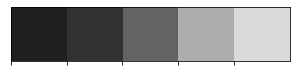

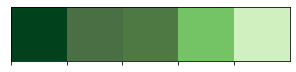

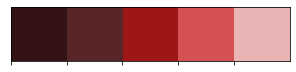

In [8]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [9]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [10]:
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")


TensorFlow **IS** using the GPU


In [12]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/glioma/Brain tumor classification','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/glioma/Brain tumor classification','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:17<00:00,  4.27it/s]


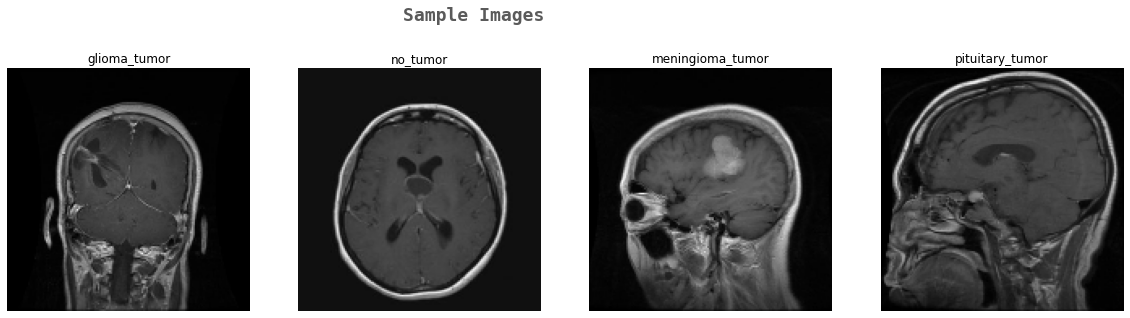

In [13]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Images',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [14]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train.shape

(3264, 150, 150, 3)

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [16]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [21]:
effnet=tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(image_size,image_size,3)
)


16719872/16705208 [==============================] - 0s 0us/step


In [36]:
  def add(self, layer):
    """Adds a layer instance on top of the layer stack.

    Arguments:
        layer: layer instance.

    Raises:
        TypeError: If `layer` is not a layer instance.
        ValueError: In case the `layer` argument does not
            know its input shape.
        ValueError: In case the `layer` argument has
            multiple output tensors, or is already connected
            somewhere else (forbidden in `Sequential` models).
    """
    # If we are passed a Keras tensor created by keras.Input(), we can extract
    # the input layer from its keras history and use that without any loss of
    # generality.
    if hasattr(layer, '_keras_history'):
      origin_layer = layer._keras_history[0]
      if isinstance(origin_layer, input_layer.InputLayer):
        layer = origin_layer


    if not isinstance(layer, base_layer.Layer):
      raise TypeError('The added layer must be '
                      'an instance of class Layer. '
                      'Found: ' + str(layer))


    tf_utils.assert_no_legacy_layers([layer])
    if not self._is_layer_name_unique(layer):
      raise ValueError('All layers added to a Sequential model '
                       'should have unique names. Name "%s" is already the name'
                       ' of a layer in this model. Update the `name` argument '
                       'to pass a unique name.' % (layer.name,))


    self.built = False
    set_inputs = False
    if not self._layers:
      if isinstance(layer, input_layer.InputLayer):
        # Case where the user passes an Input or InputLayer layer via `add`.
        set_inputs = True
      else:
        batch_shape, dtype = training_utils.get_input_shape_and_dtype(layer)
        if batch_shape:
          # Instantiate an input layer.
          x = input_layer.Input(
              batch_shape=batch_shape, dtype=dtype, name=layer.name + '_input')
          # This will build the current layer
          # and create the node connecting the current layer
          # to the input layer we just created.
          layer(x)
          set_inputs = True


      if set_inputs:
        outputs = nest.flatten(layer._inbound_nodes[-1].outputs)
        if len(outputs) != 1:
          raise ValueError(SINGLE_LAYER_OUTPUT_ERROR_MSG)
        self.outputs = outputs
        self.inputs = layer_utils.get_source_inputs(self.outputs[0])
        self.built = True
        self._has_explicit_input_shape = True


    elif self.outputs:
      # If the model is being built continuously on top of an input layer:
      # refresh its output.
      output_tensor = layer(self.outputs[0])
      if len(nest.flatten(output_tensor)) != 1:
        raise ValueError(SINGLE_LAYER_OUTPUT_ERROR_MSG)
      self.outputs = [output_tensor]
      self.built = True


    if set_inputs or self._graph_initialized:
      self._init_graph_network(self.inputs, self.outputs)
      self._graph_initialized = True
    else:
      self._layers.append(layer)
      self._handle_deferred_layer_dependencies([layer])


    self._layer_call_argspecs[layer] = tf_inspect.getfullargspec(layer.call)







In [1]:
model = effnet.output
model=tf.keras.layers.GlobalMaxPool2D(data_format=None, keepdims=False)(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='relu')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

NameError: ignored

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 151, 151, 3)  0           ['normalization[0][0]']    

In [26]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [27]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)



In [40]:
# print(tf.executing_eagerly())



False


In [41]:
# @tf.function
# def fn():
#   with tf.init_scope():
#     print(tf.executing_eagerly())
#   print(tf.executing_eagerly())
# fn()




True
False


<tf.Operation 'PartitionedCall_1' type=PartitionedCall>

In [42]:
# tf.compat.v1.disable_eager_execution()


In [28]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 1.1901 - accuracy: 0.7420
Epoch 1: val_accuracy improved from -inf to 0.88095, saving model to effnet.h5
83/83 [==============================] - 55s 372ms/step - loss: 1.1901 - accuracy: 0.7420 - val_loss: 0.3213 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.2893 - accuracy: 0.9100
Epoch 2: val_accuracy did not improve from 0.88095
83/83 [==============================] - 25s 295ms/step - loss: 0.2893 - accuracy: 0.9100 - val_loss: 0.4230 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.1900 - accuracy: 0.9387
Epoch 3: val_accuracy improved from 0.88095 to 0.93537, saving model to effnet.h5
83/83 [==============================] - 27s 321ms/step - loss: 0.1900 - accuracy: 0.9387 - val_loss: 0.2254 - val_accuracy: 0.9354 - lr: 0.0010
Epoch 4/12
83/83 [==============================] - ETA: 0s - loss: 0.2

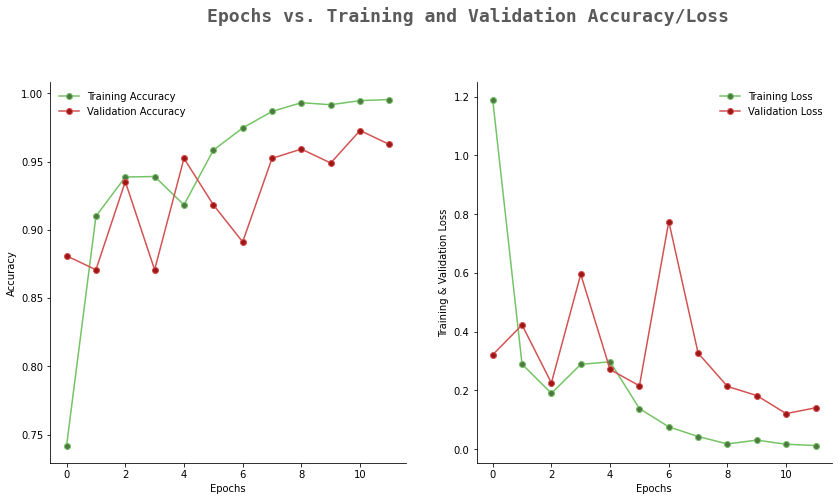

In [29]:


filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()



In [30]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [31]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        93
           1       1.00      0.96      0.98        51
           2       0.97      0.94      0.95        96
           3       0.96      0.98      0.97        87

    accuracy                           0.96       327
   macro avg       0.97      0.96      0.96       327
weighted avg       0.96      0.96      0.96       327



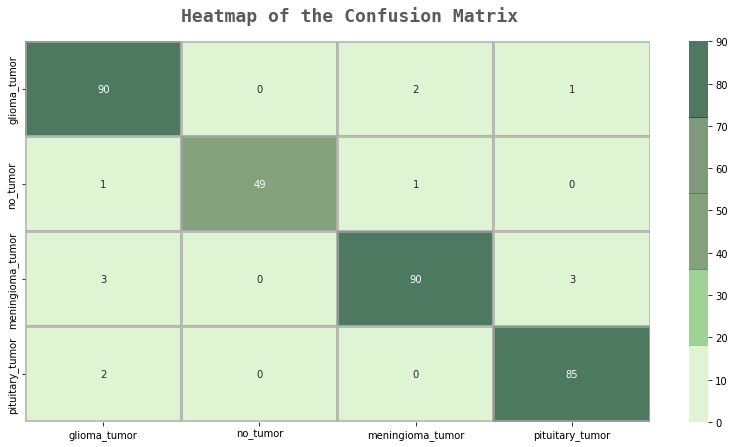

In [32]:


fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()



In [33]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [34]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [35]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

In [ ]:
# def set_options():
#     pd.set_option('display.max_columns', 100)
#     pd.set_option('display.max_colwidth', None)
#     pd.set_option('display.max_rows', 1000)
    

In [ ]:
# set_options()

In [ ]:
# import tensorflow as tf
# import pydicom 
# from tqdm import tqdm
# x = tf.constant([[1., 2., 3.],
#                  [4., 5., 6.]])

# print(x)
# print(x.shape)
# print(x.dtype)
# # x + x
# x @tf.transpose(x)

In [ ]:
# tf.concat([x, x, x], axis=0)


In [ ]:
# tf.nn.softmax(x, axis=-1)


In [ ]:
# tf.reduce_sum(x)


In [ ]:
# var = tf.Variable([0.0, 0.0, 0.0])
# var.assign([1, 2, 3])

# print(var)

In [ ]:
# Dataset containing a sparse tensor.
# dataset4 = tf.data.Dataset.from_tensors(tf.SparseTensor(indices=[[0, 0], [1, 2]], values=[1, 2], dense_shape=[3, 4]))
# tf.print(dataset4)
# dataset4.element_spec


<TensorDataset element_spec=SparseTensorSpec(TensorShape([3, 4]), tf.int32)>


SparseTensorSpec(TensorShape([3, 4]), tf.int32)

In [ ]:
from tqdm import tqdm

In [ ]:
# # for slices in tqdm(slices):
# slices=load_slices(os.getcwd())

In [ ]:
# slices[1]

In [ ]:
# dataset = tf.data.Dataset.list_files(str("/content/drive/MyDrive/pre/*.dcm"))
# print(type(dataset))
# dataset.element_spec

In [ ]:
# listdata=[]
# listdata=list(dataset)
# # listdata=list(dataset.as_numpy_iterator())
# # print(str(len(listdata))+" ------"+str(listdata))
# # print(listdata[0:2])
# print(type(listdata[1]))
# print(len(listdata))
# tf.shape(listdata[1])
# a=str(tf.print(listdata[1]))
# print(type((a)))

In [ ]:
# tag_id = tfio.image.dicom_tags.PatientsAge
# tag_value = tfio.image.decode_dicom_data(image_bytes,tag_id)
# print(tag_value)

In [ ]:
# dir=[]
# dir=os.listdir('/content/drive/MyDrive/pre')
# print(dir)

['ADCreg-79067-pre-1-18.dcm', 'MaskTumor-57060-pre-1-14.dcm']


In [ ]:
# def load_slices(path):
#     filenames = os.listdir(path)
#     slices = [pydicom.dcmread(f'{path}/{file}') for file in filenames]
#     slices.sort(key = lambda x: int(x.InstanceNumber), reverse=True)
#     return slices

In [ ]:
# def load_slices(path):
#     filenames = os.listdir(path)
#     slices = [pydicom.dcmread(f'{"/content/drive/MyDrive/pre"}/{file}') for file in filenames]
#     slices.sort(key = lambda x: int(x.InstanceNumber), reverse=True)
#     return slices

In [ ]:
# scan=load_slices("/content/drive/MyDrive/pre")


In [ ]:
# print(type(scan))

<class 'list'>


In [ ]:
# print(len(scan))

4354


In [ ]:

# def get_pixels_hu(slicess):
#     image = np.stack([s.pixel_array for s in slices])
#     # Convert to int16 (from sometimes int16), 
#     # should be possible as values should always be low enough (<32k)
#     image = image.astype(np.int16)
#     image[image <= -1000] = 0
#         # Convert to Hounsfield units (HU)
#     for slice_number in range(len(slices)):
        
#         intercept = slicess[slice_number].RescaleIntercept
#         slope = slicess[slice_number].RescaleSlope
        
#         if slope != 1:
#             image[slice_number] = slope * image[slice_number].astype(np.float64)
#             image[slice_number] = image[slice_number].astype(np.int16)
            
#         image[slice_number] += np.int16(intercept)
    
#     return np.array(image, dtype=np.int16)

In [ ]:
# image_string = tf.io.read_file("/content/drive/MyDrive/pre/nCBFreg-58401-pre-1-10.dcm")
# image = tfio.image.decode_dicom_image(image_string, dtype=tf.uint16)
# image = tf.image.convert_image_dtype(image, tf.float32)
# skipped = tfio.image.decode_dicom_image(image_string, on_error='skip', dtype=tf.uint8)
# # lossy_image = tfio.image.decode_dicom_image(image_string, scale="Auto", on_error='lossy', dtype=tf.uint8)
# # # image_bytes = tf.io.read_file(c)
# # # #Don't use tf.image.decode_image, or the output shape will be undefined
# # image = tfio.image.decode_image(image_string, channels=3)
# # # #This will convert to float values in [0, 1]
# # # image = tf.image.resize_images(image, [64, 64])
# # # return resized_image, label
# fig, axes = plt.subplots(1,2, figsize=(15,15))
# axes[0].imshow(np.squeeze(image.numpy()))
# axes[0].set_title("parts")
# axes[1].imshow(np.squeeze(skipped.numpy()), cmap='gray')
# axes[1].set_title('lossy image')

In [ ]:
# test=np.array(image_string)
# print(tf.shape(test))

tf.Tensor([], shape=(0,), dtype=int32)


In [ ]:
# hu_img=get_pixels_hu(scan[])

In [ ]:
# fig,ax = plt.subplots(1,2,figsize=(20,5))
# example = train.loc[0]['Patient']
# scans = load_slices(f'{TRAIN_IMG_PATH}/{example}')
# rescaled_images=get_pixels_hu(scans)
# images = [scan.pixel_array for scan in scans]
# for i in range(10):
#     sns.distplot(images[i].flatten(), ax=ax[0])
#     sns.distplot(rescaled_images[i].flatten(), ax=ax[1])
# ax[0].set_title("Raw pixel array distributions for 10 examples")
# ax[1].set_title("HU unit distributions for 10 examples")

In [ ]:
# def get_dicom_raw(dicom):
#     return ({attr:getattr(dicom, attr) for attr in dir(dicom) if attr[0].isupper() and attr not in ['PixelData']})

In [ ]:
# get_dicom_raw(image_string)[0]

In [ ]:
# %%time
# # Get dicom metadata
# # Image features like lung volume are implementation from a detailed discussion "Domain expert's insight" by Dr. Konya.
# # https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/165727

# def get_dicom_metadata(df):
#     slices = df.slices.unique()
#     dicom_metadata = []
#     for i in listdata:
#         path = f'{os.getcwd()}'
#         img_list = os.listdir(path)
#         for img in img_list:
#             image = pydicom.dcmread(f'{path}/{img}')
#             record = get_dicom_raw(image)
#             raw = image.pixel_array
#             pixelspacing_r, pixelspacing_c = image.PixelSpacing[0], image.PixelSpacing[1]
#             row_distance = pixelspacing_r * image.Rows
#             col_distance = pixelspacing_c * image.Columns
#             record.update({'raw_min':raw.min(),
#                         'raw_max':raw.max(),
#                         'raw_mean':raw.mean(),
#                         'raw_std':raw.std(),
#                         'raw_diff':raw.max()-raw.min(),
#                         'pixel_spacing_area':pixelspacing_r * pixelspacing_c,
#                         'img_area':image.Rows * image.Columns,
#                         'pixel_row_distance':row_distance,
#                         'pixel_col_distance':col_distance,
#                         'slice_area_cm2':(0.1 * row_distance) * (0.1 * col_distance),
#                         'slice_vol_cm3':(0.1 * image.SliceThickness) * (0.1 * row_distance) * (0.1 * col_distance),
#                         'patient_img_path':f'{path}/{img}'})

#             dicom_metadata.append(record)
            
#     metadata_df = pd.DataFrame(dicom_metadata)
#     metadata_df.to_pickle('metadata_df.pkl')
#     return metadata_df

In [ ]:
# f=get_dicom_metadata(slice[1])

In [ ]:
# slices[1]

In [ ]:
# train, test = tf.keras.datasets.pre.load_data()


In [ ]:
# import tensorflow_io_gcs_filesystem as tfio

# image_bytes = tf.io.read_file('dicom_00000001_000.dcm')

# image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)

# skipped = tfio.image.decode_dicom_image(image_bytes, on_error='skip', dtype=tf.uint8)

# lossy_image = tfio.image.decode_dicom_image(image_bytes, scale='auto', on_error='lossy', dtype=tf.uint8)


# fig, axes = plt.subplots(1,2, figsize=(10,10))
# axes[0].imshow(np.squeeze(image.numpy()), cmap='gray')
# axes[0].set_title('image')
# axes[1].imshow(np.squeeze(lossy_image.numpy()), cmap='gray')
# axes[1].set_title('lossy image');
